In [1]:
import torch
import numpy as np
import sys
sys.path.append('../duq/')
import pre
import post
import copy
import sgld as SG
import matplotlib.pyplot as plt

Device =  cpu


In [26]:
def plot_result(m, sd, caption, mode):
    fig, ax = plt.subplots(1,2,figsize=(20, 5),dpi=500)

    X = np.arange(0,M+1)
    Xtick = X.copy()
    
    m_main = m[:-1]
    sd_main = sd[:-1]
    percent_main = 100*(sd[:-1]/m[:-1])
    ax[0].bar(X,m_main)
    ax[0].set_title(f"Mean: {caption}")
    ax[0].set_xticks(Xtick)
    
    if mode=="SD":
        ax[1].bar(X,sd_main,color='gray')
        ax[1].set_title(f"SD: {caption}")
        ax[1].set_xticks(Xtick)
    else:
        ax[1].bar(X,percent_main,color='c')
        ax[1].set_title(f"Percent Uncert: {caption}")
        ax[1].set_xticks(Xtick)
    
    ax[0].bar(len(X),m[-1],color='g')
    ax[0].set_title(f"Mean: {caption}")

In [12]:

import pandas as pd
# num_x, num_y, num_z, width_x, width_y, width_z, freq1, freq2, freq3, freq4, freq5, freq6, L2 dist
# [0]    [1]    [2]    [3]      [4]      [5]      [6]    [7]    [8]    [9]    [10]   [11]   [12]

y_cols = [6]             # Which column(s) does the the dependent variable(s) that we're interested in sit? list
x_cols = [0,1,2,3,4,5]   # Which column(s) is the independent variable(s) (features) in? list
component = "n/a"        # this is used if we want to sort and split the data by a particular parameter

# Import the csv file and save as DataFrame
filepath = '../data/all_data.csv'
#filepath = '../data/delet_me.csv'
df_orig = pd.read_csv(filepath, header=None)
df_orig.columns = ['nbays_x', 'nbays_y', 'nbays_z', 'bay_width_x', 'bay_width_y', 'bay_width_z', 'modal_freq_1', 'modal_freq_2', 'modal_freq_3', 'modal_freq_4', 'modal_freq_5', 'modal_freq_6']

data_mean = df_orig.mean()
data_std = df_orig.std()

# Visualise full dataset in reduced dimensional space 
_, components = post.PCA_transformdata(df_orig.iloc[:,x_cols], return_components=True)

ood_lims_in = [[0., 3.], [0., 3.], [0., 3.], [0., 5.], [0., 5.], [0., 5.]]
train_lims_all = [[3., 10], [3., 10], [3., 10], [5., 10], [5., 10], [5., 10]]
ood_lims_out = [[10, 25], [10, 25], [10, 30], [10, 12], [10, 12], [10, 12]]

TRAIN, VAL, TEST = pre.split_by_bounds(df=df_orig,
                                 x_cols=x_cols,
                                 y_cols=y_cols,
                                 train_lims_all=train_lims_all,
                                 ood_lims_in=ood_lims_in,
                                 ood_lims_out=ood_lims_out,
                                 data_mean=data_mean, 
                                 data_std=data_std, 
                                 PCA_components=components,
                                 val_split=0.1,
                                 verbose=False,
                                 plots=False,
                                 figsize=(10,10))

x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

y_train_unnorm = pre.unnormalise(y_train,data_mean[y_cols].values,data_std[y_cols].values)
y_val_unnorm = pre.unnormalise(y_val,data_mean[y_cols].values,data_std[y_cols].values)
y_test_unnorm = pre.unnormalise(y_test,data_mean[y_cols].values,data_std[y_cols].values)

In [50]:
M = 30

err_train = np.zeros((M+2, 2)) #post.count_wrong_preds(samples_train, y_train_np, 1, "SD", False)
err_test = np.zeros((M+2, 2)) #post.count_wrong_preds(samples_test, y_test_np, 1, "SD", False)
err_val = np.zeros((M+2, 2)) #post.count_wrong_preds(samples_val, y_val_np, 1, "SD", False)

s_m_train = np.zeros(M+2)
s_sd_train = np.zeros(M+2)
s_m_test = np.zeros(M+2)
s_sd_test = np.zeros(M+2)
s_m_val = np.zeros(M+2)
s_sd_val = np.zeros(M+2)

uncert_train = np.zeros(M+2)
uncert_test = np.zeros(M+2)
uncert_val = np.zeros(M+2)


excluded_models = [30, 28, 17]  #  These give clearly crazy results

for i in range(1, M+1):
    if i%5 == 0: print(f"{i}th model")
    if i not in excluded_models:
        model = torch.load(f"../trained_models/for_prediction/MC_{i}")
        samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
        samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
        samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)
        
        err_train[i,:] = post.count_wrong_preds(samples_train, y_train_np, 1, "SD", verbose=False)
        err_test[i,:] = post.count_wrong_preds(samples_test, y_test_np, 1, "SD", verbose=False)
        err_val[i,:] = post.count_wrong_preds(samples_val, y_val_np, 1, "SD", verbose=False)
        
        # Train
        samples_error_train = np.array(np.abs([samples_train.squeeze()[j,:]-y_train_np for j in range(samples_train.shape[0])])).flatten()
        s_m_train[i] = np.mean(samples_error_train)
        s_sd_train[i] = np.std(samples_error_train)
        
        # Test
        samples_error_test = np.array(np.abs([samples_test.squeeze()[j,:]-y_test_np for j in range(samples_test.shape[0])])).flatten()
        s_m_test[i] = np.mean(samples_error_test)
        s_sd_test[i] = np.std(samples_error_test)
        
        # Val
        samples_error_val = np.array(np.abs([samples_val.squeeze()[j,:]-y_val_np for j in range(samples_val.shape[0])])).flatten()
        s_m_val[i] = np.mean(samples_error_val)
        s_sd_val[i] = np.std(samples_error_val)
        
        # Uncertainty %
        uncert_train[i] = np.mean(np.abs(100*stds_train/means_train))
        uncert_test[i] = np.mean(np.abs(100*stds_test/means_test))
        uncert_val[i] = np.mean(np.abs(100*stds_val/means_val))
        
        # Exclude a model if the amount of incorrect predictions exceeds 20%
        # Incorrect here being defined as the true value not being captured
        # within the uncertainty region
        if (np.sum(err_train[i,:])/len(x_train) >= 0.02):
            excluded_models.append(i)
            print(f"Excluding model {i}")
            err_train[i,:] = 0
            err_test[i,:] = 0
            err_val[i,:] = 0
            s_m_train[i] = 0
            s_sd_train[i] = 0
            s_m_test[i] = 0
            s_sd_test[i] = 0
            s_m_val[i] = 0
            s_sd_val[i] = 0
            uncert_train[i] = 0
            uncert_test[i] = 0
            uncert_val[i] = 0
            continue
        
        # Exclude any clearly wrong results, where it incorrectly
        # predicts 100% of the validation points. 
        # Using same definition of error as above 
        if (np.sum(err_val[i,:])/len(x_val) == 1):
            excluded_models.append(i)
            print(f"Excluding model {i}")
            err_train[i,:] = 0
            err_test[i,:] = 0
            err_val[i,:] = 0
            s_m_train[i] = 0
            s_sd_train[i] = 0
            s_m_test[i] = 0
            s_sd_test[i] = 0
            s_m_val[i] = 0
            s_sd_val[i] = 0
            uncert_train[i] = 0
            uncert_test[i] = 0
            uncert_val[i] = 0
            continue
            
    elif i in excluded_models:
        err_train[i,:] = 0
        err_test[i,:] = 0
        err_val[i,:] = 0


Excluding model 2
5th model
10th model
Excluding model 10
Excluding model 11
Excluding model 12
15th model
Excluding model 18
Excluding model 19
20th model
Excluding model 20
Excluding model 21
Excluding model 22
Excluding model 23
Excluding model 24
25th model
Excluding model 25
Excluding model 26
Excluding model 27
30th model


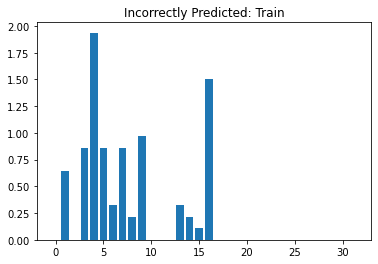

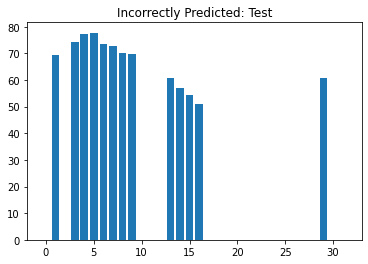

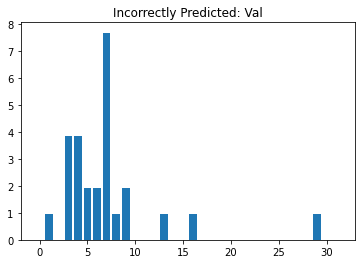

In [51]:
X = np.arange(0,M+2)

err_train_total = 100*np.sum(err_train,axis=1)/len(x_train)
plt.figure()
plt.bar(X, err_train_total)
plt.title("Untrustworthy Predictions: Train");

err_test_total = 100*np.sum(err_test,axis=1)/len(x_test)
plt.figure()
plt.bar(X, err_test_total)
plt.title("Untrustworthy Predictions: Test");

err_val_total = 100*np.sum(err_val,axis=1)/len(x_val)
plt.figure()
plt.bar(X, err_val_total)
plt.title("Untrustworthy Predictions: Val");

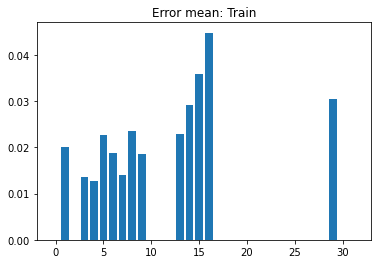

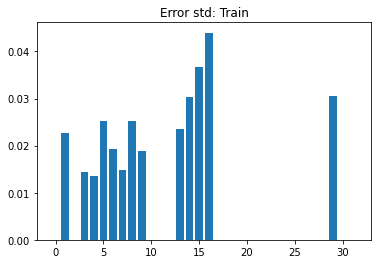

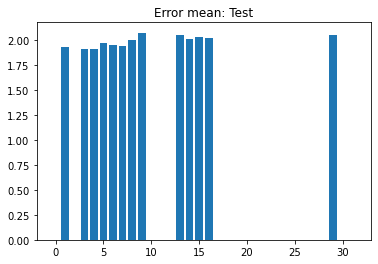

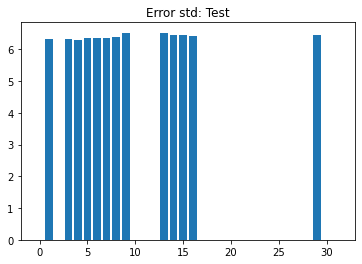

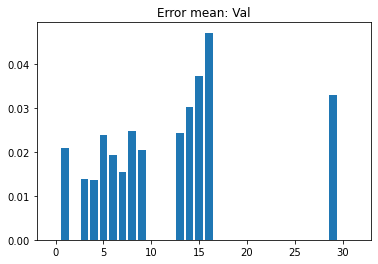

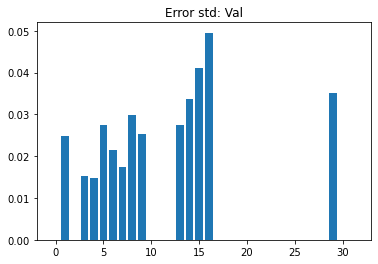

In [52]:
X = np.arange(0,M+2)

plt.figure()
plt.bar(X, s_m_train)
plt.title("Error mean: Train");

plt.figure()
plt.bar(X, s_sd_train)
plt.title("Error std: Train");

plt.figure()
plt.bar(X, s_m_test)
plt.title("Error mean: Test");

plt.figure()
plt.bar(X, s_sd_test)
plt.title("Error std: Test");

plt.figure()
plt.bar(X, s_m_val)
plt.title("Error mean: Val");

plt.figure()
plt.bar(X, s_sd_val)
plt.title("Error std: Val");

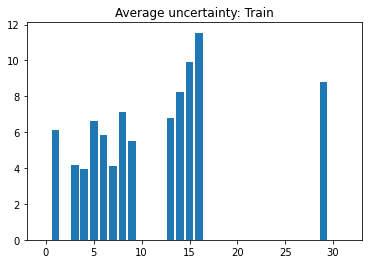

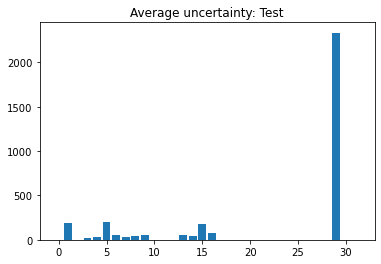

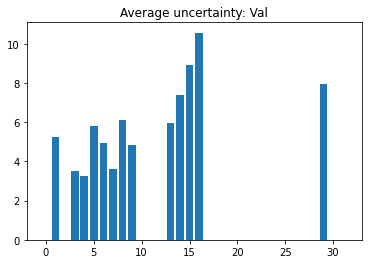

In [53]:
X = np.arange(0,M+2)

uncert_train.shape
plt.figure()
plt.bar(X, uncert_train)
plt.title("Average uncertainty: Train");

plt.figure()
plt.bar(X, uncert_test)
plt.title("Average uncertainty: Test");

plt.figure()
plt.bar(X, uncert_val)
plt.title("Average uncertainty: Val");

In [54]:

#m = np.zeros(N+1)
#sd = np.zeros(N+1)
x = np.array([[3, 3, 3, 5, 5, 5],      #1
             [7, 7, 7, 7.5, 7.5, 7.5], #2
             [10, 10, 10, 10, 10, 10], #3
             [15, 15, 15, 15, 15, 15], #4
             [30, 30, 30, 25, 25, 25], #5
             [30, 30, 50, 30, 30, 30], #6
             [40, 40, 50, 30, 30, 30], #7
             [1, 1, 1, 1, 1, 1],       #8
             [2, 2, 2, 2, 2, 2],       #9
             [3, 3, 3, 3, 3, 3]])      #10

#excluded_models = []#[17, 19, 21]#[17, 21]#[18,20]

In [55]:
# Cycle through all the models and calculate mean and std for chosen models

m = np.zeros((M+2, x.shape[0]))
sd = np.zeros((M+2, x.shape[0]))

for i in range(1, M+1):
    if i not in excluded_models:
        model = torch.load(f"../trained_models/for_prediction/SGLD_{i}")
        #print(f"Loading model {i}...")
        for j in range(x.shape[0]):
        #    print(f"x{j}")
            #print(f"setting model {i} and x{j}")
            s, m[i,j], sd[i, j] = model.make_prediction(x[j])
    elif i in excluded_models:
        s, m[i,j], sd[i, j] = 0, 0, 0

C:\Users\aolux\AppData\Local\Temp\ipykernel_15028\2151853347.py:9: RuntimeWarning: invalid value encountered in true_divide
  percent_main = 100*(sd[:-1]/m[:-1])


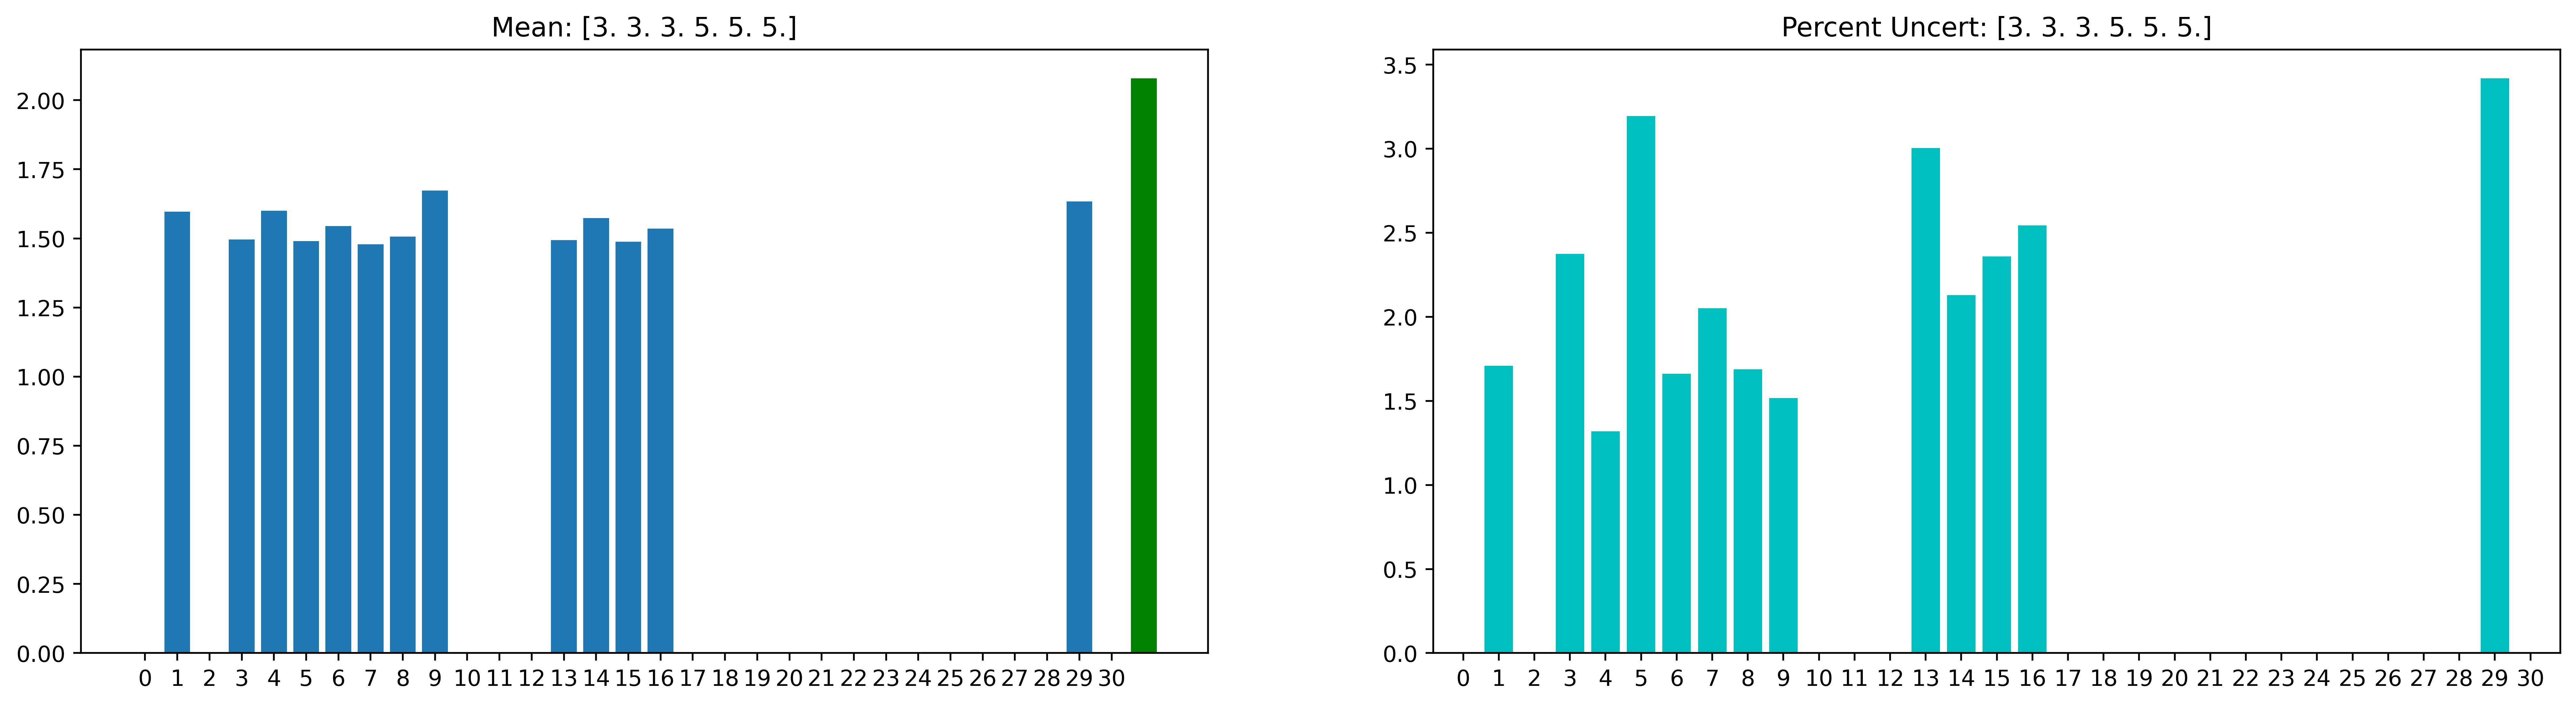

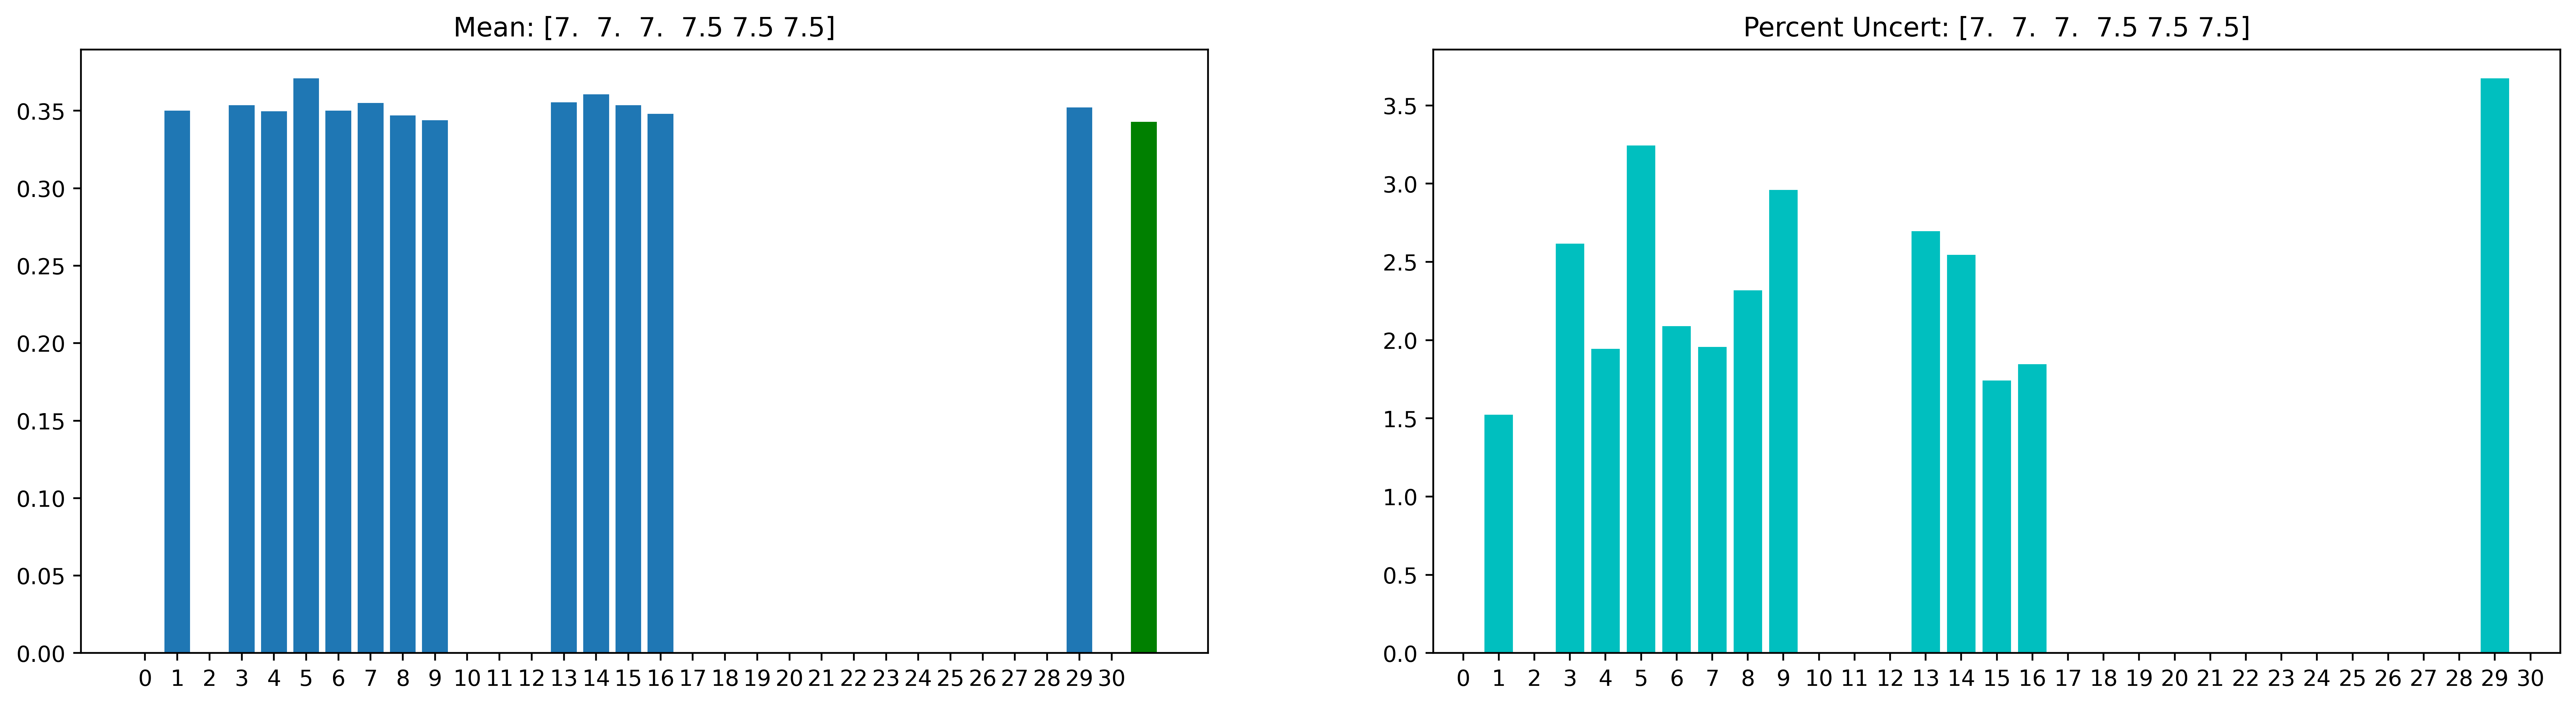

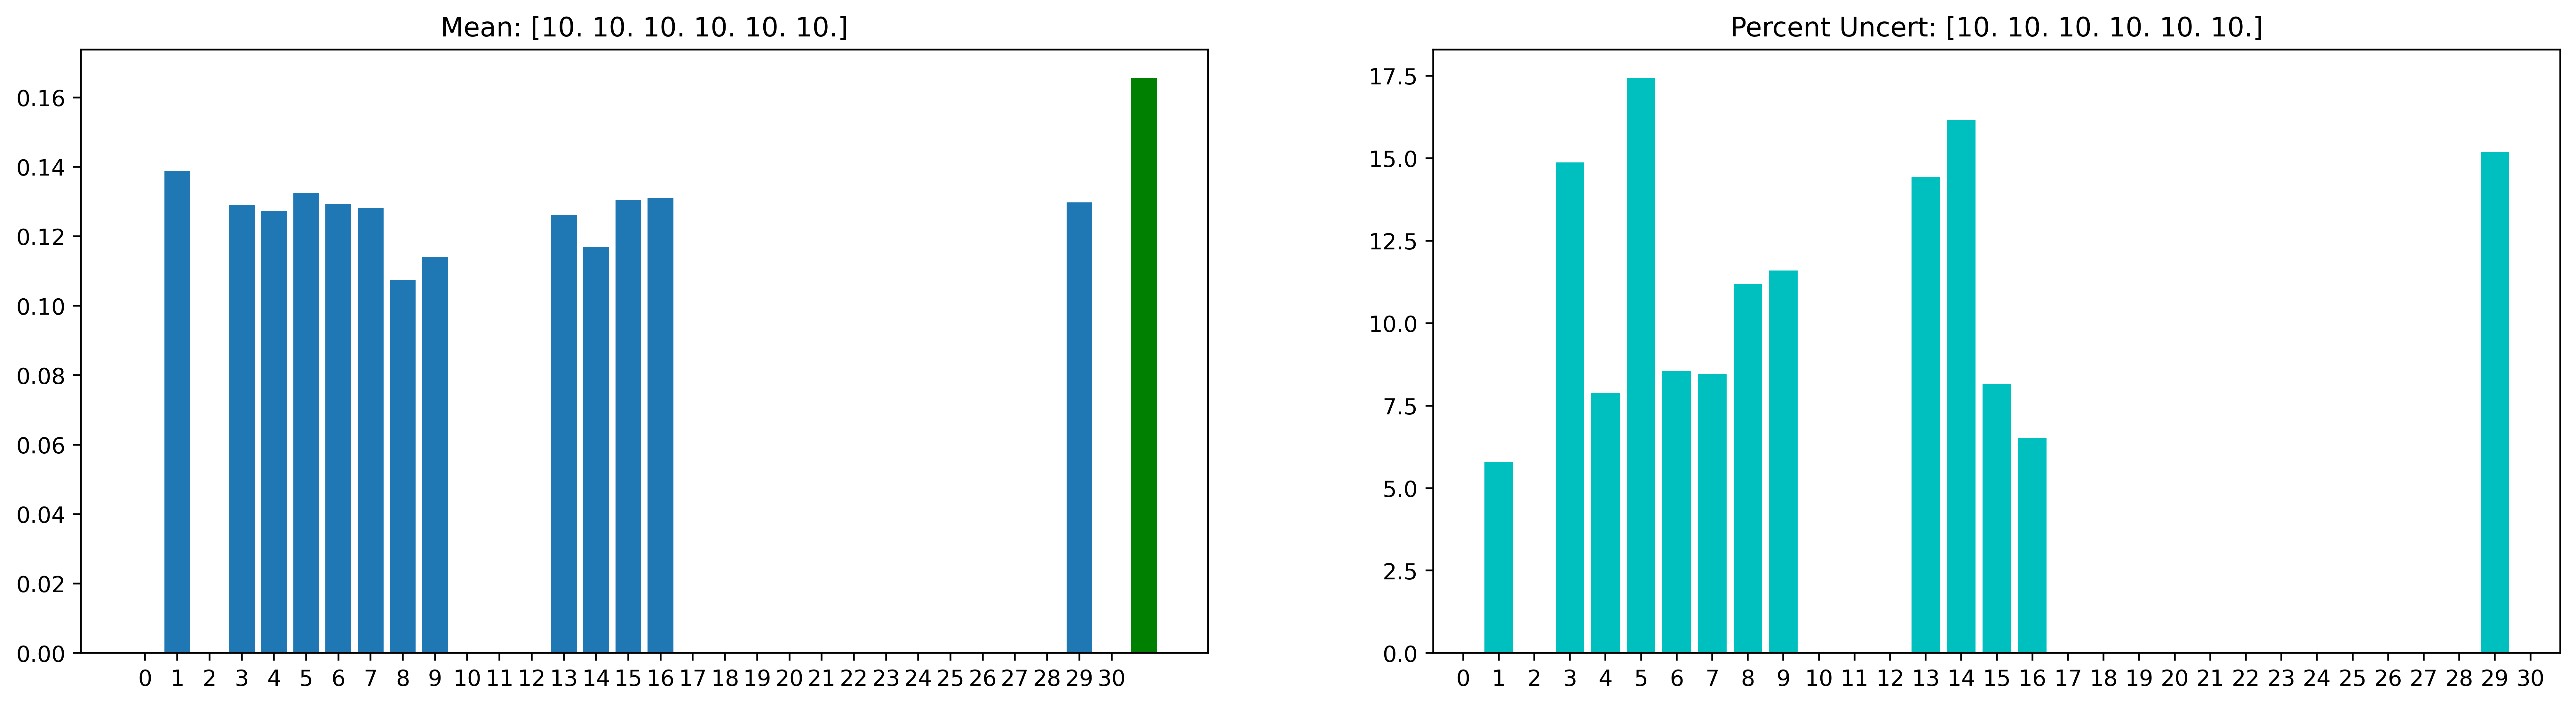

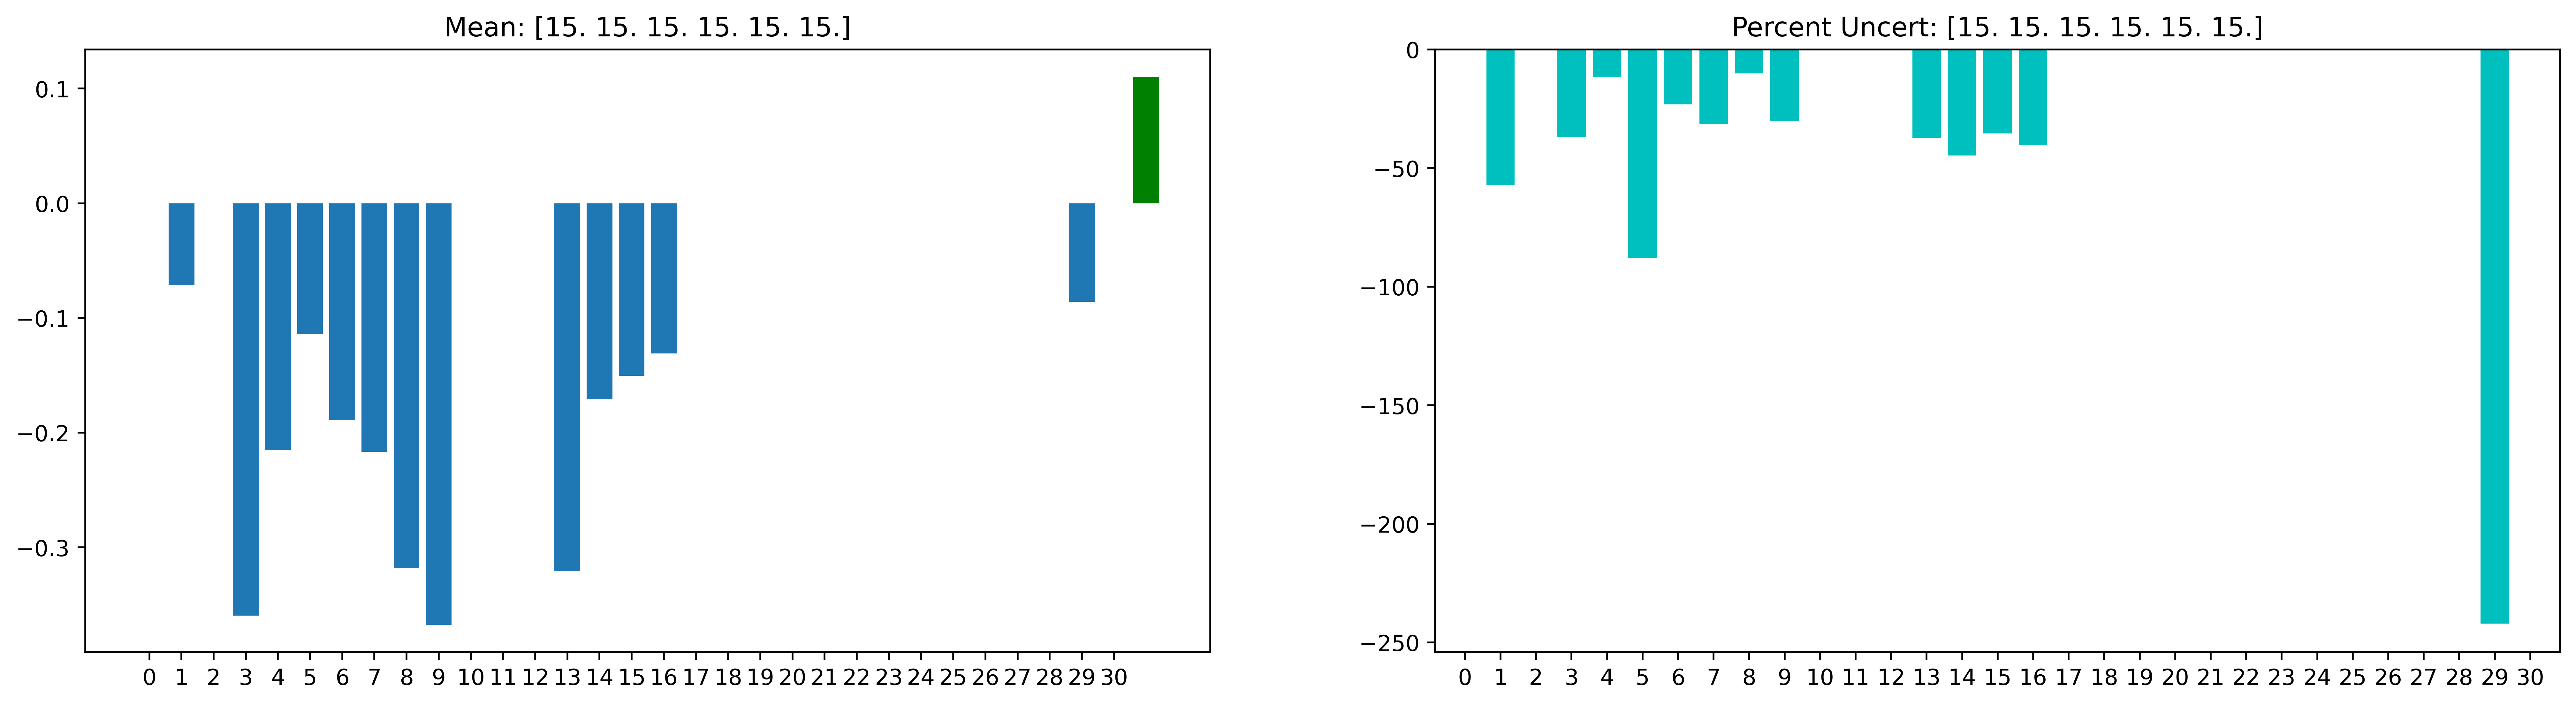

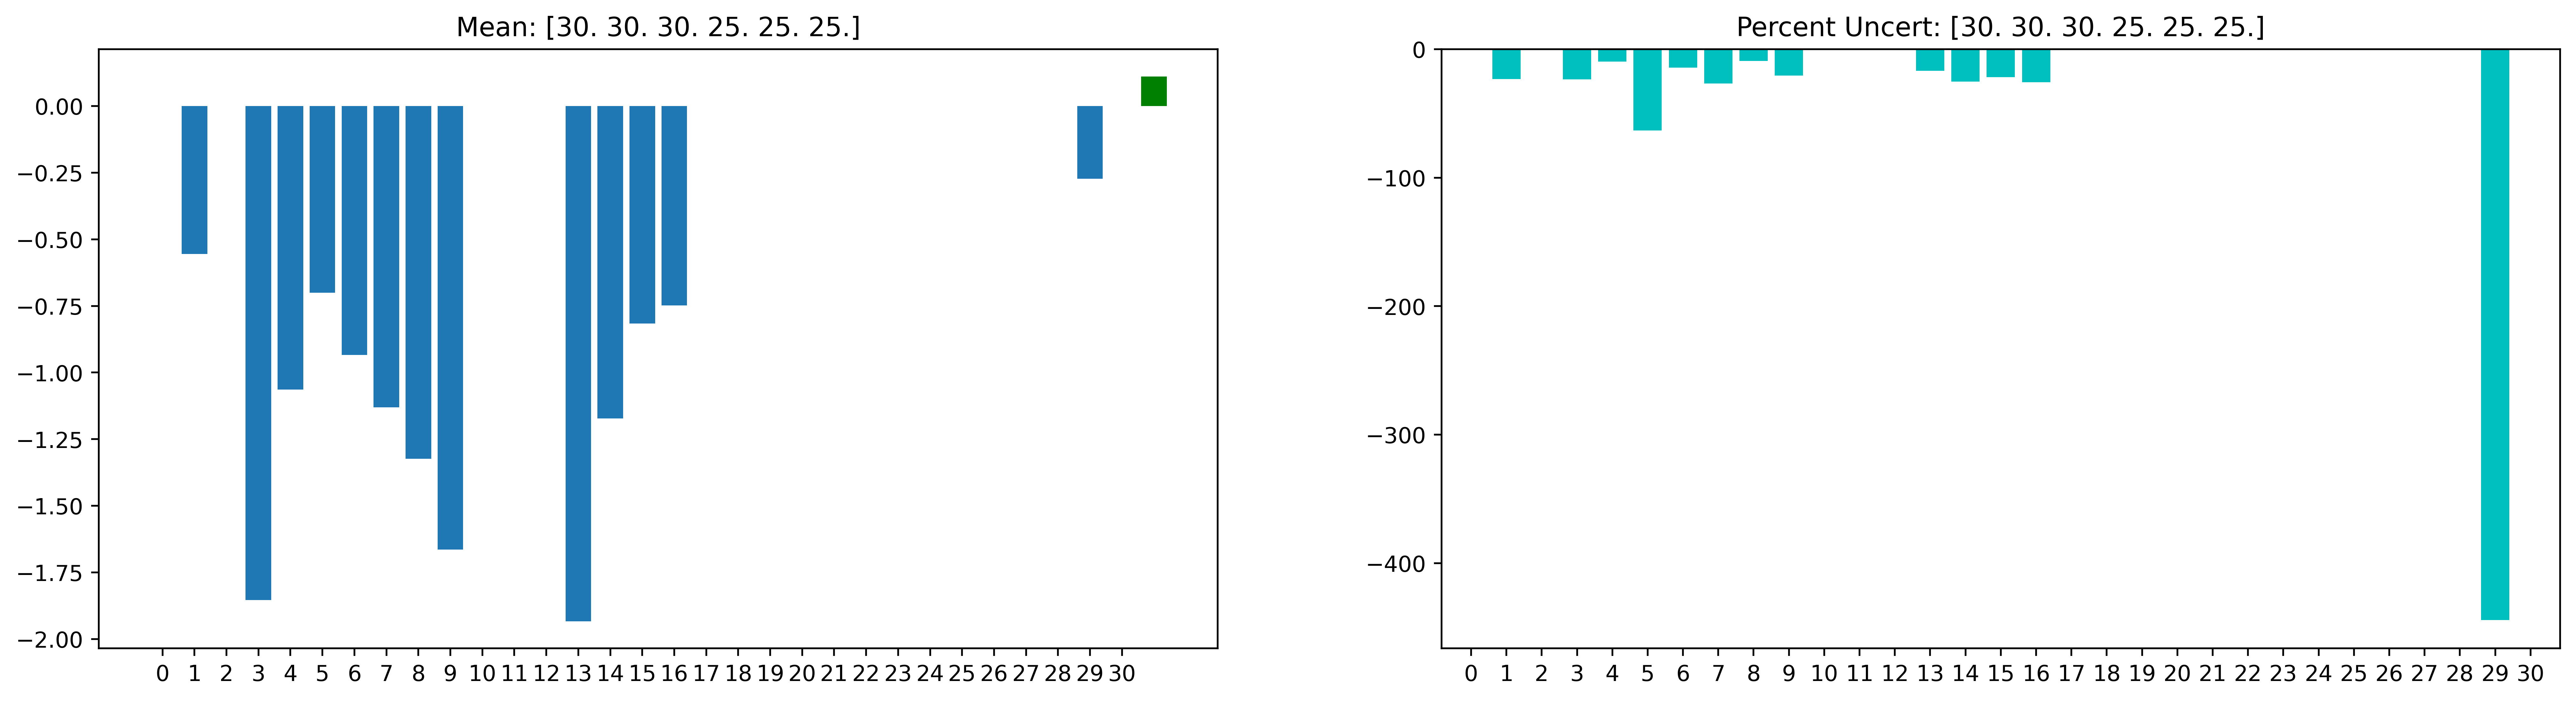

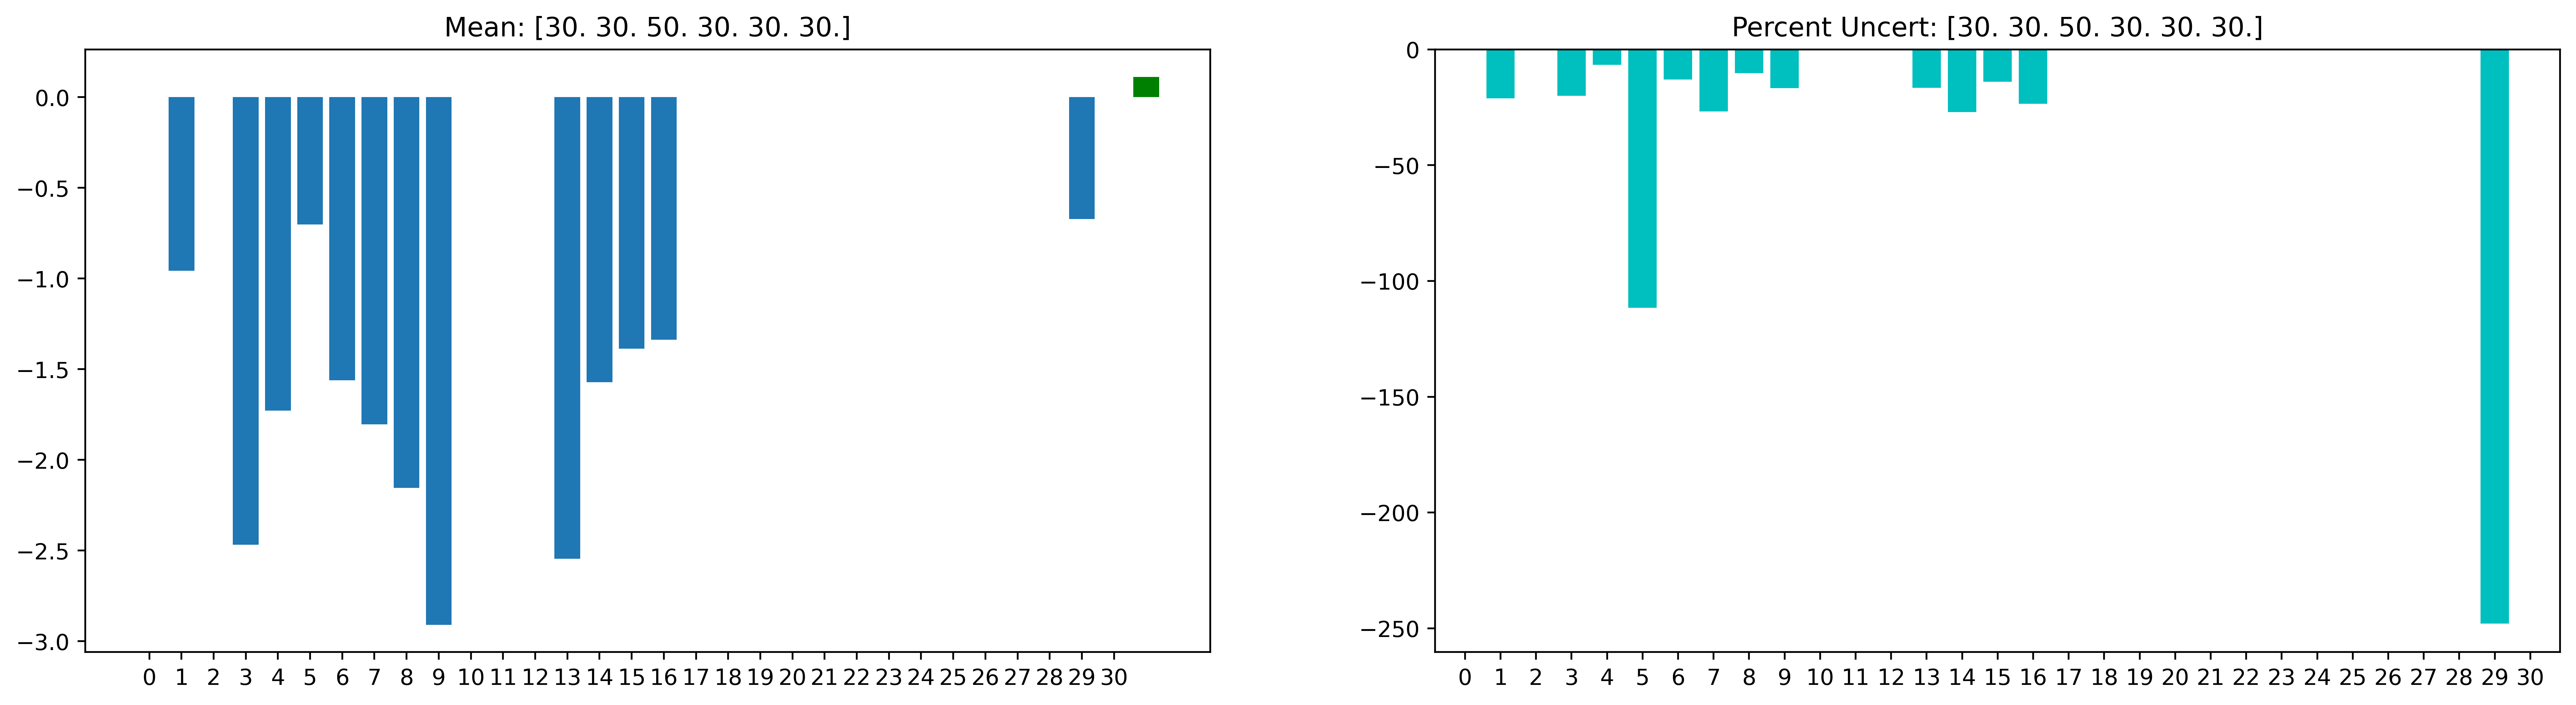

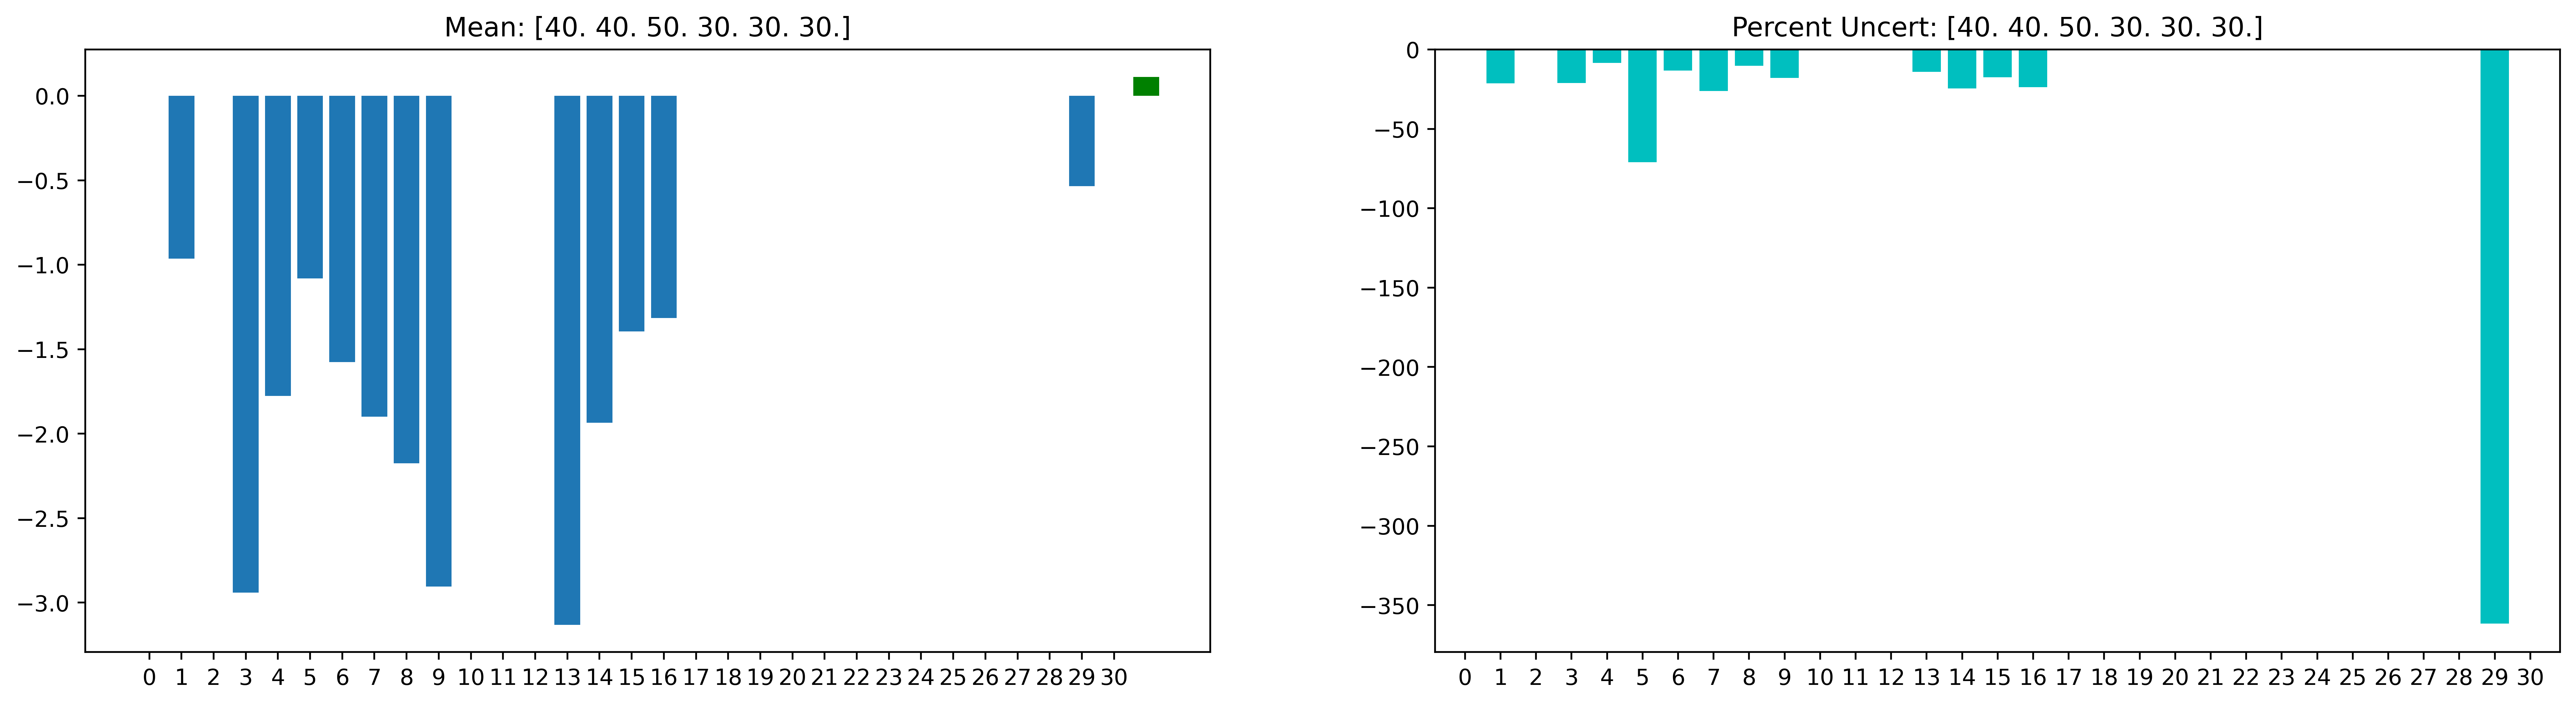

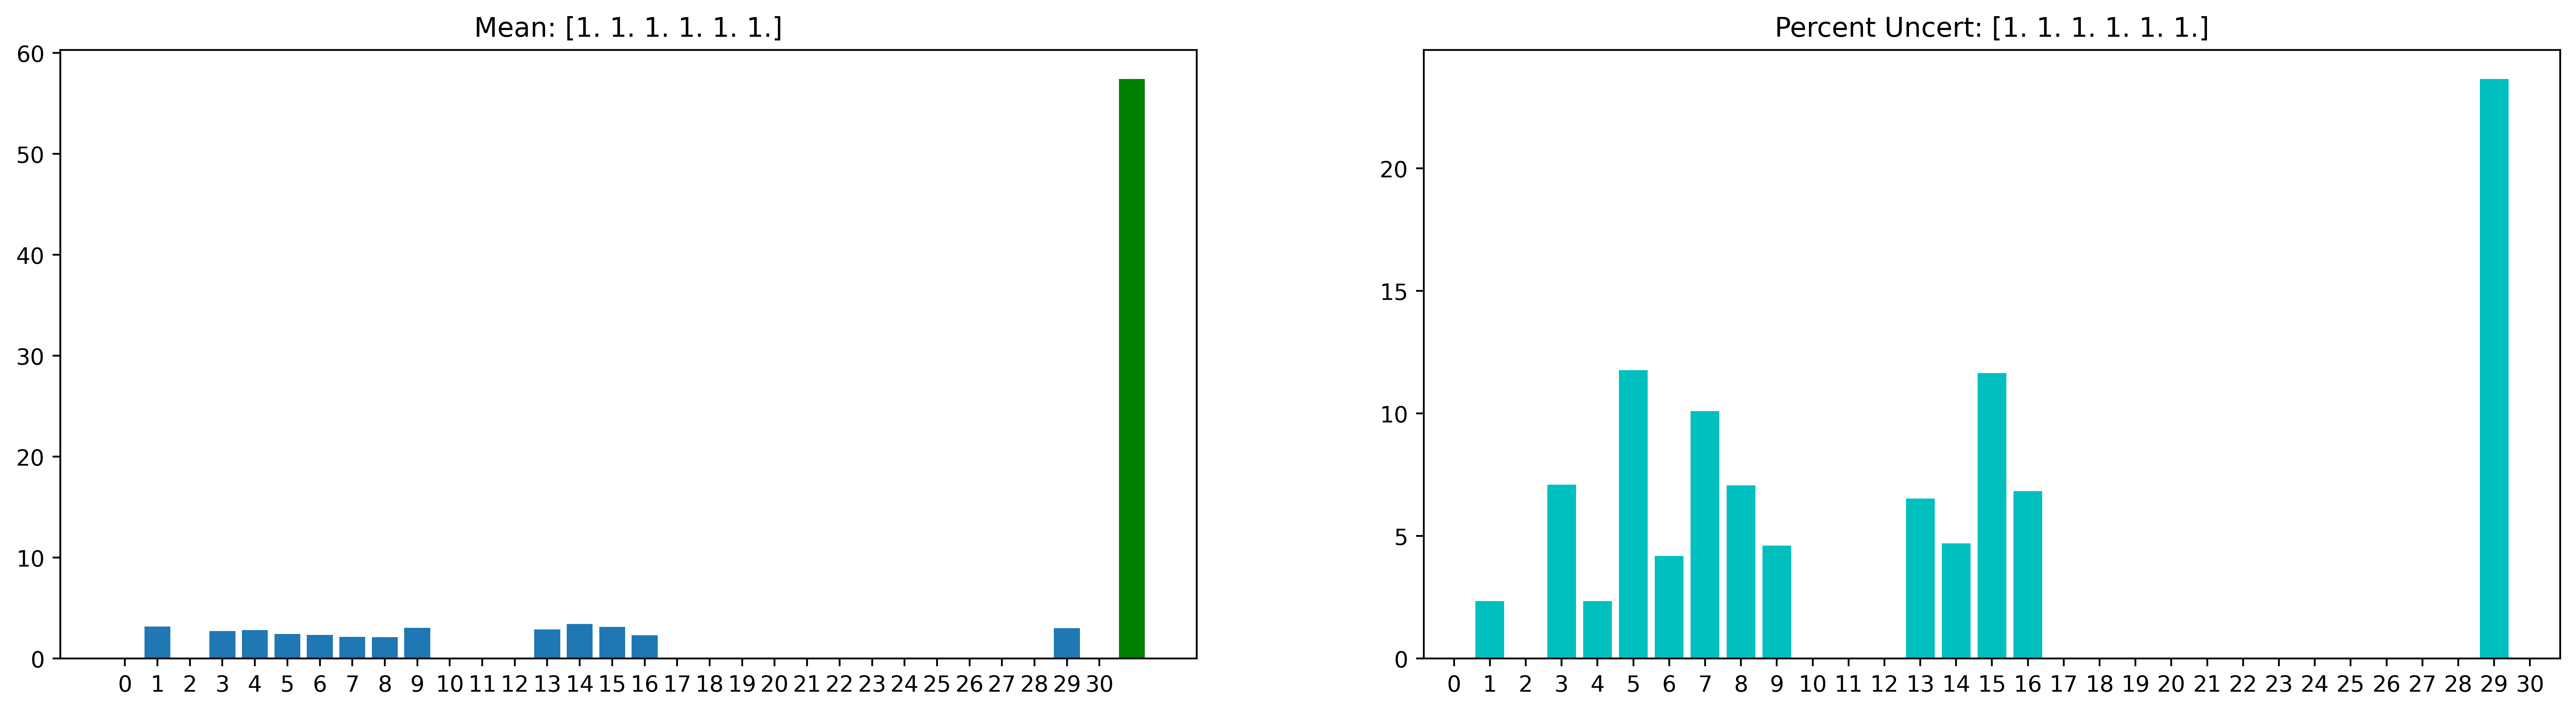

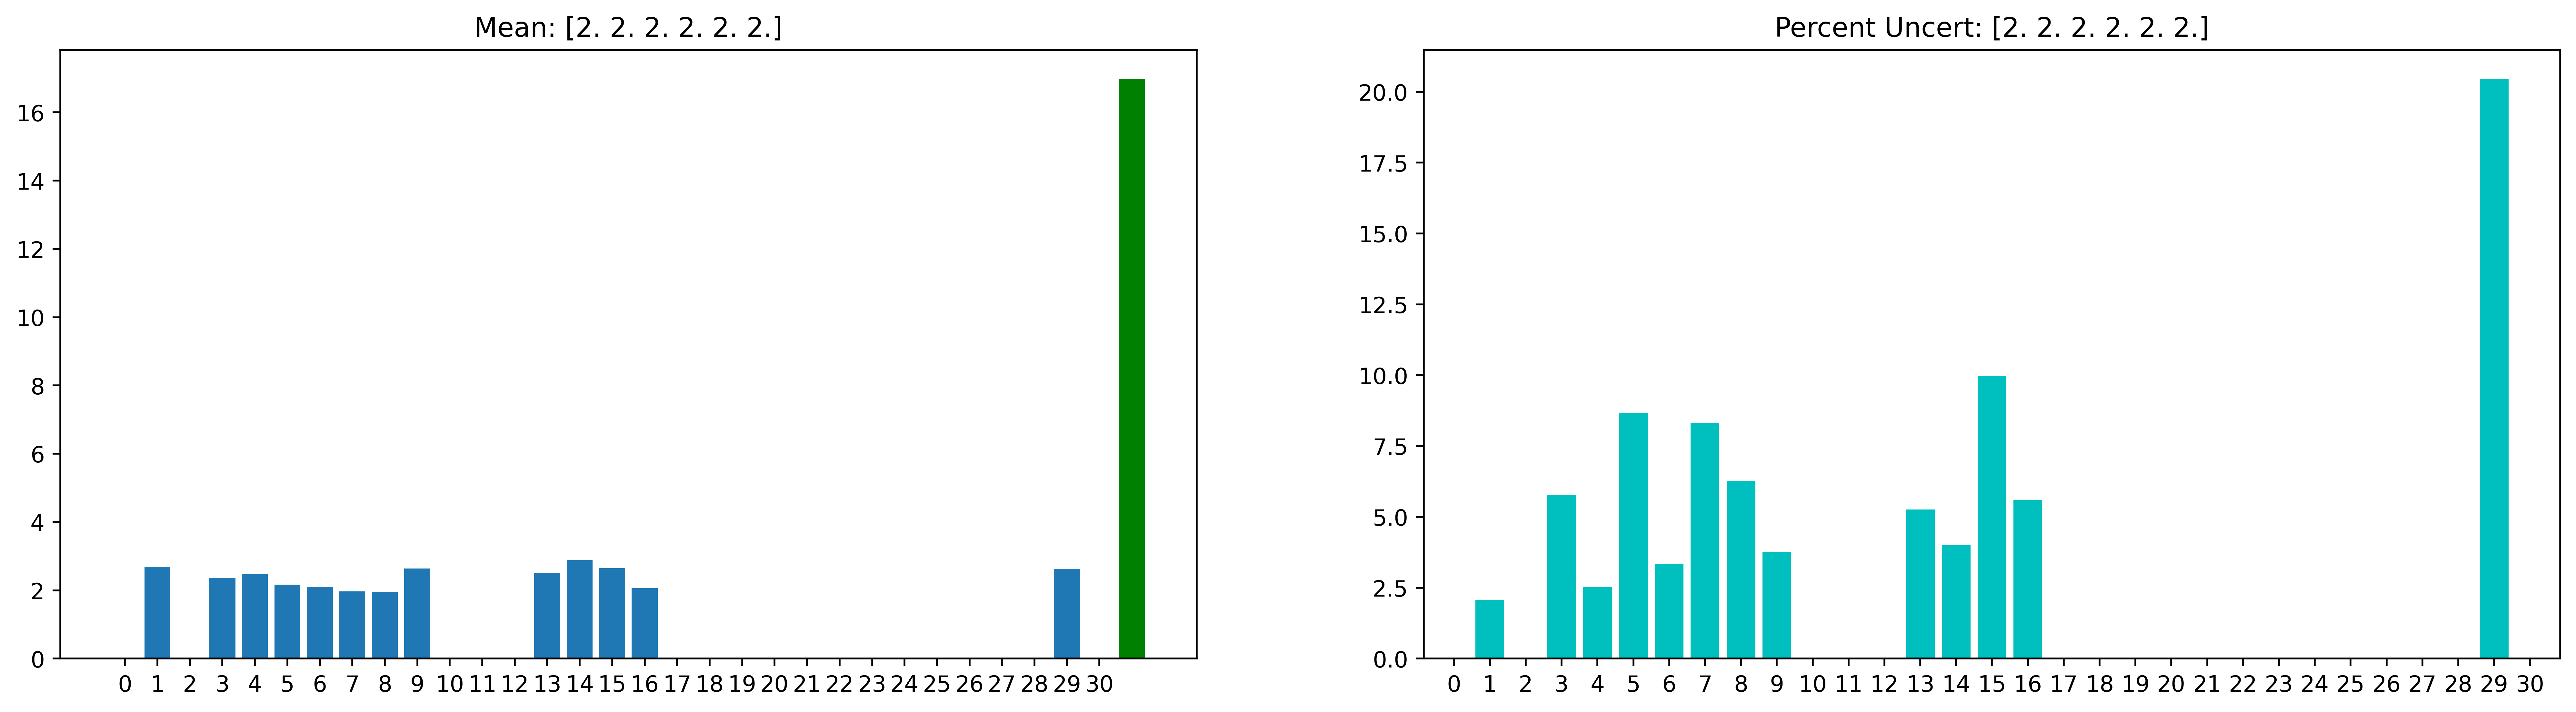

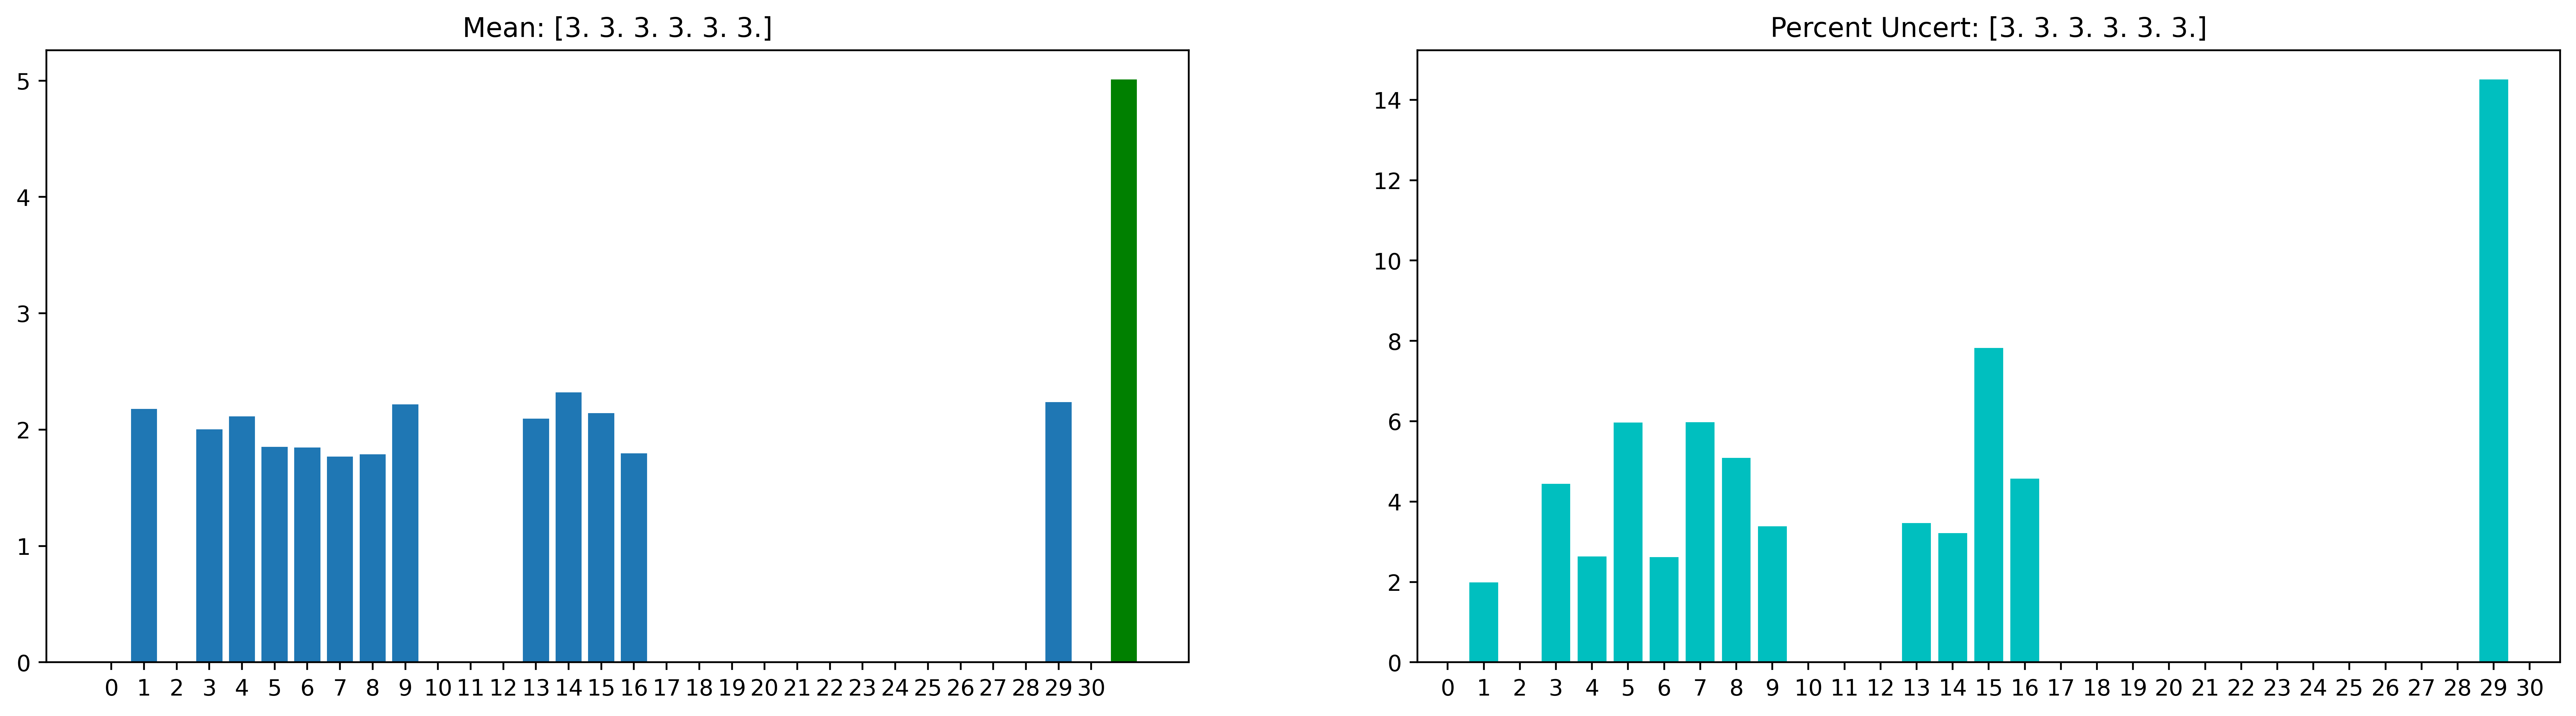

In [56]:
# Plot the results
reference_model = torch.load(f"../trained_models/for_prediction/MCDropout_reference")

for j in range(x.shape[0]):
    s, m[-1, j], sd[-1, j] = reference_model.make_prediction(x[j])
    plot_result(m[:,j], sd[:,j], f"{x[j]}", "percent")
